In [1]:
# use boost env
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json

sns.set_style('darkgrid')

In [31]:
! pwd

/Users/marialentini/Library/CloudStorage/OneDrive-PearsonPLC/Rowan/PrescriptionTree


In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate sythetic datasets

In [3]:
# import synthetic data generator
from SyntheticData import SyntheticData
data_generator = SyntheticData()

In [4]:
def max_plot(results, title):
    """
    Print optimal average revenue based on model. 
    Return box plots of purchases (0: no purchase or 1: purchase) over price,
    scatter plot of the first two covariates and price, and a histogram
    of the optimal price over the distribution of individuals.
    """
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))

    sns.boxplot(data=results, x='Y', y='price', ax = ax[0])
    sns.scatterplot(data=results, x='X0', y='X1', hue='price', ax=ax[1])
    sns.histplot(data=results, x='optimal_price', ax=ax[2])
    plt.suptitle(title)

    ax[2].set_ylabel("Sample Count")
    ax[2].set_xlabel("Optimal Price")
    
    print('Optimal Average Revenue:', results.loc[results.optimal_price > 0, 'optimal_price'].sum() / len(results))
    print("Average Observed Sales Revenue:", results.loc[results.Y == 1, 'price'].sum() / len(results))

Optimal Average Revenue: 4.952790990058362
Average Observed Sales Revenue: 2.2229670653162183


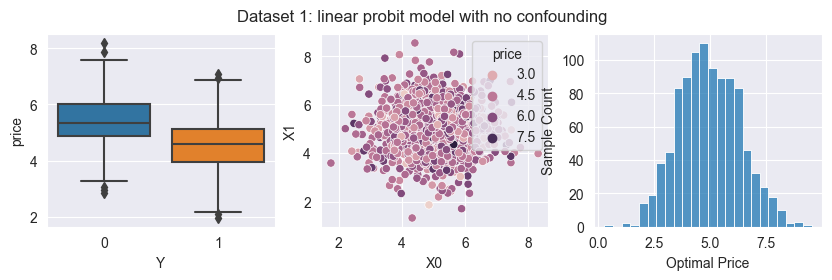

In [72]:
# plot dataset 1
model_id = 1
results = data_generator.generate_data(model_id=model_id, n_samples=1000)
max_plot(results, "Dataset {}: linear probit model with no confounding".format(model_id))

Optimal Average Revenue: 8.501733999348875
Average Observed Sales Revenue: 0.06057966884915404


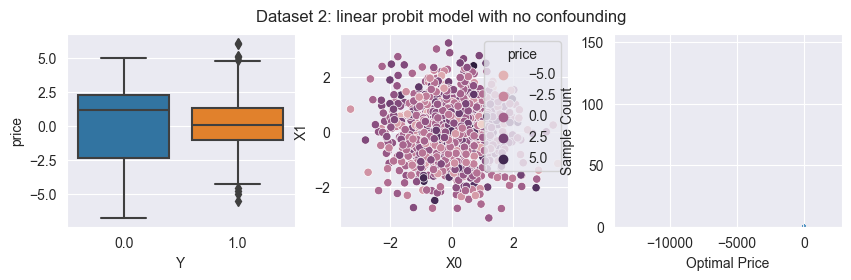

In [73]:
# plot dataset 2
model_id = 2
results = data_generator.generate_data(model_id=model_id, n_samples=1000)
max_plot(results, "Dataset {}: linear probit model with no confounding".format(model_id))

Optimal Average Revenue: 5.074417979316992
Average Observed Sales Revenue: 1.8824093027854005


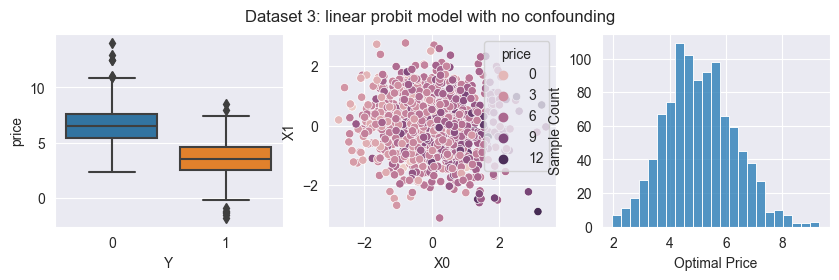

In [74]:
model_id = 3
results = data_generator.generate_data(model_id=model_id, n_samples=1000)
max_plot(results, "Dataset {}: linear probit model with no confounding".format(model_id))

Optimal Average Revenue: 5.212372719773965
Average Observed Sales Revenue: 1.987383884512111


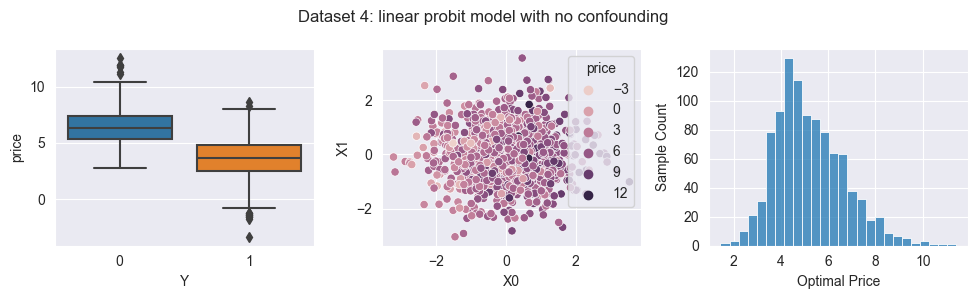

In [11]:
# plot dataset 4
model_id = 4
results = data_generator.generate_data(model_id=model_id, n_samples=1000)
max_plot(results, "Dataset {}: linear probit model with no confounding".format(model_id))

plt.tight_layout()
plt.savefig('figures/dataset4 1000 samples')

Optimal Average Revenue: 5.1072707724715105
Average Observed Sales Revenue: 0.0768304896966423


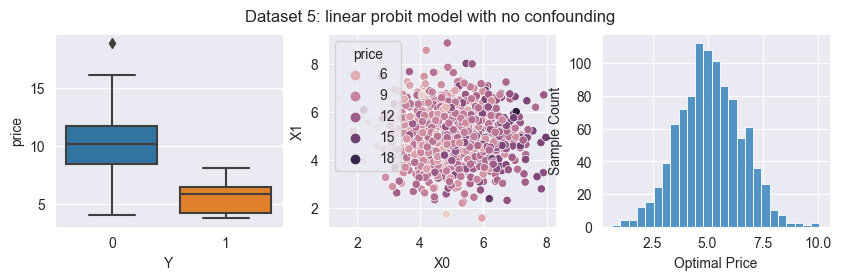

In [77]:
# plot dataset 5
model_id = 5
results = data_generator.generate_data(model_id=model_id, n_samples=1000)
max_plot(results, "Dataset {}: linear probit model with no confounding".format(model_id))

Optimal Average Revenue: 4.57600081588129
Average Observed Sales Revenue: 1.1444811505288661


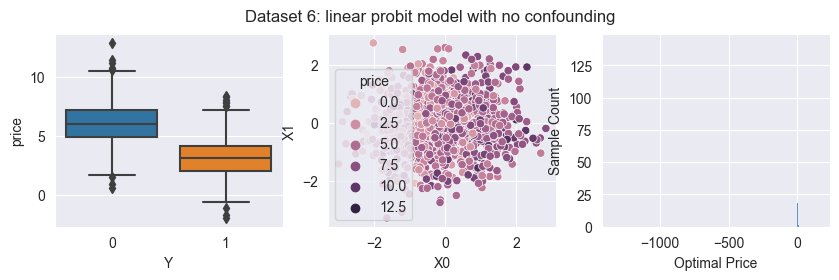

In [78]:
# plot dataset 6
model_id = 6
results = data_generator.generate_data(model_id=6, n_samples=1000)
max_plot(results, "Dataset {}: linear probit model with no confounding".format(model_id))

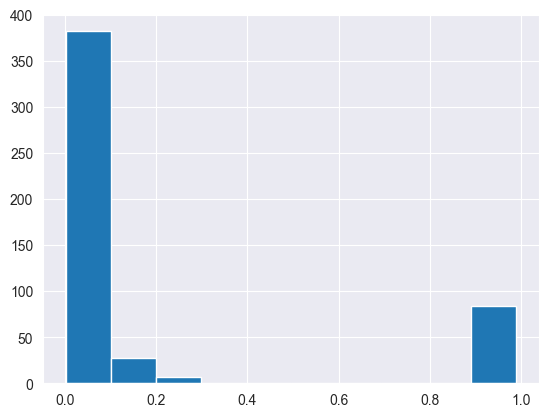

[ 7.20941471  7.91752096  8.6256272   9.33373344 10.04183969 10.74994593
 11.45805217 12.16615842 12.87426466]
Root node best Price 7.209414711314772
4.953188838861666
Revenue 0.018667466884909174


In [53]:
from math import floor

model_id = 5
results = data_generator.generate_data(model_id=model_id, n_samples=1000)

n_samples = len(results)
def get_X_y(data):
    covariates = [x for x in data.columns if x not in ['optimal_price', 'Y', 'purchase_prob']]
    X = data[covariates]
    y = data['Y']
    return X, y

# split into train and test
n = floor(n_samples / 2)
data_train, data_test = results[:n], results[n:]

# outcome variable is only required in 
# the training data to train teacher model
X_train, y_train = get_X_y(data_train)
X_test, _ = get_X_y(data_test)            
price_thresh = data_test['optimal_price']

# lightGBM
num_round = 50 
model = lgb.LGBMClassifier(n_estimators=num_round)

# fix imbalance over training set only
covars = [x for x in X_train.columns if "X" in x] + ['price']
model.fit(X_train[covars], y_train)

counterfactual = X_test.copy()
price = 2.5
counterfactual.price = price

plt.hist(model.predict_proba(counterfactual)[:, 1])
plt.show()

low_price = X_train.price.quantile(0.10)
high_price = X_train.price.quantile(0.90)
prices = np.linspace(low_price, high_price, 9)

def get_revenue_matrix(X):
    # make empty response matrix
    revenue_matrix = np.empty((len(X), len(prices)))

    for i in range(len(prices)):
        counterfactual = X.copy()
        price = prices[i]
        counterfactual.price = price

        # construct reponse matrix
        revenue_matrix[:, i] = price * model.predict_proba(counterfactual)[:, 1]

    return revenue_matrix

revenue_matrix = get_revenue_matrix(X_train)
best_price = np.argmax(revenue_matrix.sum(axis=0))

def get_true_revenue_matrix(prices, X, price_thresh):
    """
    Get revenue matrix corresponding to ground truth
    generative probability distribution
    X: data
    prices: descretized prices
    """
    # make empty response matrix
    revenue_matrix = np.empty((len(X), len(prices)))

    for i, price in enumerate(prices):
        # construct reponse matrix
        # price threshold used to determine
        # sale outcome
        revenue_matrix[:, i] = (price < price_thresh) * price

    return revenue_matrix

print(prices)
print("Root node best Price", prices[best_price])

true_revenue_matrix = get_true_revenue_matrix(prices, X_test[covars], price_thresh) / len(X_test)
print(results.loc[results.optimal_price > 2.5, 'optimal_price'].sum() / len(results))

print("Revenue", true_revenue_matrix[:, 3].sum())

In [54]:
results.optimal_price.mean()

5.028205873672494

# Evaluate SPT on synthetic data

In [9]:
from RunExperiments import RunExperiments
experiment = RunExperiments()

In [7]:
# varying size experiment
print("Running varying size experiment . . .")
experiment.run(
    experiment="varyingSize", 
    path="results/TEST_TRIAL.json", 
    model_ids=[5], 
    n_samples=[100, 300, 1000, 3000, 10000], 
    n_iter=10, 
    depths=3,
    overwrite=True
)

Running varying size experiment . . .


NameError: name 'experiment' is not defined

In [79]:
# varying depth experiment
print("Running varying depth experiment . . .")
experiment.run(
    experiment="varyingDepth", 
    path="results/spt_experiments.json", 
    model_ids=[6], 
    n_samples=5000, 
    n_iter=10, 
    depths=[1, 2, 3, 4, 5],
    overwrite=True
)

Running varying depth experiment . . .


100%|██████████| 10/10 [00:33<00:00,  3.35s/it]


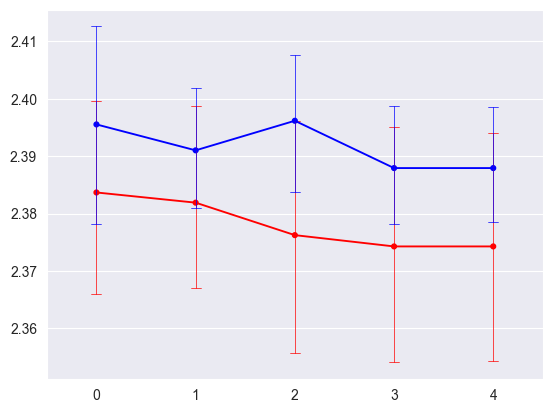

In [80]:
with open('results/TEST_TRIAL.json', 'r') as f:
    data = json.load(f)
    

fig, ax = plt.subplots()

colors = ['red', 'blue']
for i, x in enumerate(['spt', 'opt']):
# for j, exper in enumerate(['varyingDepth', 'varyingSize']):
    x = np.array(experiment.results[6]['varyingDepth'][x])
    sns.pointplot(
        data=x, 
        errorbar=('ci', 90), 
        color=colors[i],
        linestyles='-',
        capsize=.1,
        scale=0.5,
        errwidth=0.5,
        ax=ax,
    )
        # print(x.mean(axis=0))

#plt.ylim(x.min(), x.max())

In [58]:
# varying depth experiment
print("Running varying depth experiment . . .")
experiment.run(
    experiment="varyingDepth", 
    path="results/spt_experiments.json", 
    model_ids=[5], 
    n_samples=10000, 
    n_iter=10, 
    depths=[1, 2, 3, 4, 5],
    overwrite=True
)

Running varying depth experiment . . .


100%|██████████| 10/10 [01:27<00:00,  8.77s/it]


In [13]:
# varying size experiment
print("Running varying size experiment . . .")
experiment.run(
    experiment="varyingSize", 
    path="results/spt_experiments.json", 
    model_ids=[1, 3, 4], 
    n_samples=[100, 300, 1000, 3000, 10000], 
    n_iter=10, 
    depths=3,
    overwrite=True
)

Running varying size experiment . . .


 80%|████████  | 8/10 [01:34<00:23, 11.78s/it]


KeyError: 'price'

In [11]:
# write results into json log
experiment.update_results_log()

{'varyingDepth': {'spt': [[0.46442226935199676, 0.4644222693519969, 0.46442226935199676, 0.46442226935199676, 0.46442226935199676], [0.4446543842049792, 0.4446543842049792, 0.4446543842049792, 0.4432292098966299, 0.4432292098966299], [0.4442545193912634, 0.4428168025000295, 0.4442545193912634, 0.4442545193912634, 0.4442545193912634], [0.48608703290487376, 0.48608703290487376, 0.48608703290487365, 0.48608703290487365, 0.48608703290487365], [0.2830830749616532, 0.25765064909906726, 0.26736587481235435, 0.27136575501680565, 0.27136575501680565], [0.4410833015970744, 0.4392225832568396, 0.44488030116276667, 0.4448803011627666, 0.4448803011627666], [0.4809267866336853, 0.48092678663368527, 0.48092678663368527, 0.48092678663368515, 0.48092678663368515], [0.43792429155355694, 0.43792429155355694, 0.43792429155355683, 0.43792429155355683, 0.43792429155355683], [0.44423111100677687, 0.4442311110067768, 0.4442311110067768, 0.4442311110067768, 0.4442311110067768], [0.2908810315960309, 0.305596344

## Plot results

In [3]:
# format plot
from matplotlib.lines import Line2D

def plot_results(results, model_id):
    fig, ax = plt.subplots(1, 2, figsize=(12, 2))

    colors = ['red', 'blue']
    for j, model in enumerate(['spt', 'opt']):
        for i, experiment_title in enumerate(['varyingDepth', 'varyingSize']):
            # plot SPT results
            x = np.array(results[model_id]['{}'.format(experiment_title)]['{}'.format(model)])
            sns.pointplot(
                data=x, 
                errorbar=('ci', 90), 
                color=colors[j],
                linestyles='-',
                capsize=.1,
                scale=0.5,
                errwidth=0.5,
                ax=ax[i],
            )
            print(x.mean(axis=0))


    a = Line2D([], [], label='SPT')
    b = Line2D([], [], label='Optimal', linestyle='--')
    plt.legend(handles=[a, b])
    plt.suptitle('Dataset {}'.format(str(model_id)))

    # ax[0].set_ylim(3.1, 3.6)
    ax[0].set_xticks(ticks=range(5), labels=[1, 2, 3, 4, 5])
    ax[0].set_xlabel("Depth")
    ax[0].set_ylabel("Avg. Revenue")
    ax[0].grid(True) 

    ax[1].grid(True)
    ax[1].set_xticks(ticks=range(5), labels=[100, 300, 1000, 3000, 10000])
    ax[1].set_xlabel('Training Data Size')
    ax[1].set_ylabel('Avg. Revenue')

    plt.show()

[3.15430953 3.21327611 3.21801477 3.21041247 3.21041247]
[2.68278406 3.01059    3.1095718  3.1051359  3.16021103]
[3.21488671 3.25823766 3.27214932 3.2730155  3.2730155 ]
[3.18402177 3.2544135  3.25871294 3.263992   3.24143648]


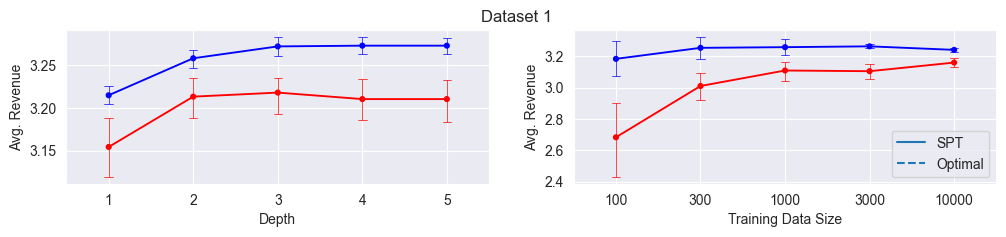

[3.36714952 3.36694192 3.35312908 3.34625253 3.34625253]
[2.93038934 3.19521794 3.20853198 3.26866032 3.39619233]
[3.40212649 3.43510201 3.43510201 3.43510201 3.43510201]
[3.32137972 3.43074565 3.38132887 3.43637893 3.43174553]


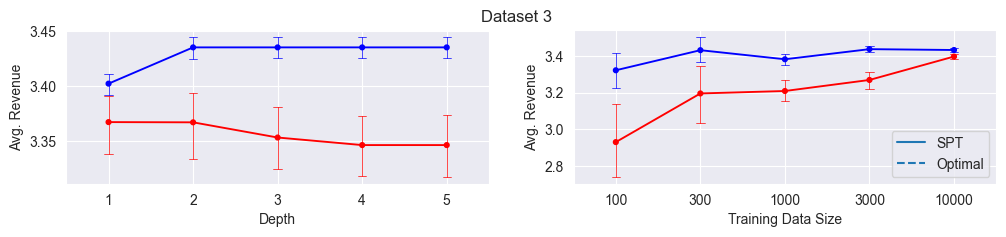

[3.27601482 3.3274795  3.33761949 3.33585379 3.33585379]
[2.8379965  3.06666753 3.22869848 3.33912095 3.33334501]
[3.3066745  3.41011691 3.44269375 3.44331283 3.44331283]
[3.36541953 3.37763181 3.4099621  3.40912416 3.41404721]


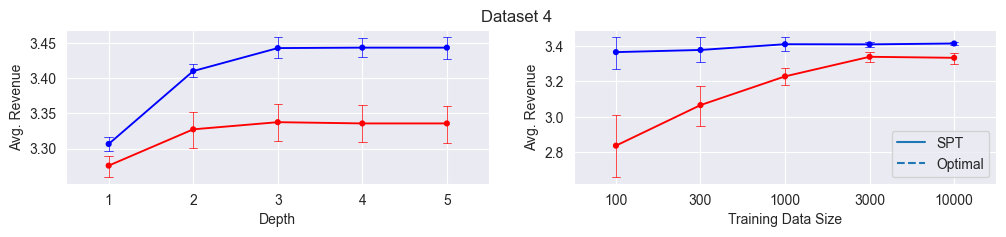

[0.42175478 0.42035323 0.42203429 0.42256323 0.42256323]
[0.20651461 0.16521169 0.07367165 0.10705972 0.05257965]
[0.45980143 0.45980143 0.45980143 0.45980143 0.45980143]
[0.11991045 0.15658848 0.07367165 0.09292214 0.1235807 ]


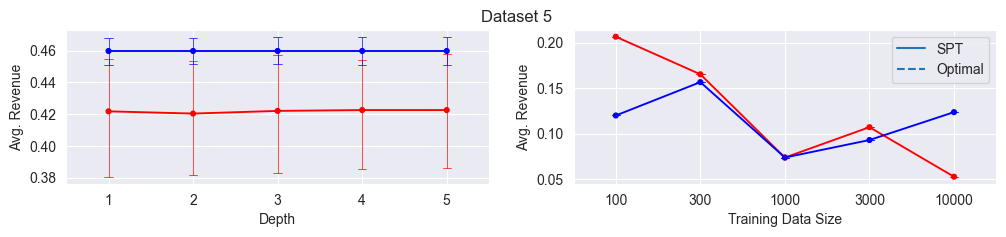

In [4]:
with open('results/spt_experiments.json', 'r') as f:
    data = json.load(f)
    
model_id = str(4)
for model_id in [str(i) for i in [1, 3, 4, 5]]:
    plot_results(data, model_id)

In [108]:
model_ids = [str(i) for i in [1, 3, 4]]

experimental_results = []
for model_id in model_ids:
    temp = []
    for j, model in enumerate(['spt', 'opt']):
        # plot SPT results
        temp.append(
            np.array(data[model_id]['{}'.format("varyingDepth")][model]).mean()
        )
    experimental_results.append(temp)

pd.DataFrame(np.array(experimental_results), index=model_ids, columns=['SPT', 'Optimal']).round(2)

,SPT,Optimal
1,3.20,3.26
3,3.36,3.43
4,3.32,3.41


# Risk-Averse SPT
A risk averse tree should mitigate risk and stabilize variance over 

In [1]:
# use pymc_env2 env
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
import seaborn as sns

In [5]:
# get synthetic data
model_id = 1
n_samples = 100
data = data_generator.generate_data(model_id=model_id, n_samples=n_samples)  

# get data
covariates = [x for x in data.columns if x not in ['Y', 'price', 'optimal_price']]
print("Covariates:", covariates)

X = data[covariates].transpose().to_numpy()
y = data['Y']
price = data['price']

X.shape

Covariates: ['X0', 'X1']


(2, 100)

In [6]:
d = X.shape[0] # dim of covariate space

with pm.Model() as model:
    # prior scale
    theta_a = pm.InverseGamma("theta_a", 1, 1)
    theta_b = pm.InverseGamma("theta_b", 1, 1)

    # slopes
    alpha = pm.MvNormal("alpha", mu=[0] * d, cov=theta_a*np.identity(d))
    beta = pm.MvNormal("beta", mu=[0] * d, cov=theta_b*np.identity(d))

    p_bar = pm.Deterministic(
        "p_bar", 
        pm.math.invlogit(
            pm.math.dot(alpha, X) + pm.math.dot(beta, X) * price
        )
    )

    # expected success rate
    A = pm.Binomial("y", observed=y, n=[1] * len(y), p=p_bar)
    trace = pm.sample(draws=1000, tune=2000, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_a, theta_b, alpha, beta]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 410 seconds.


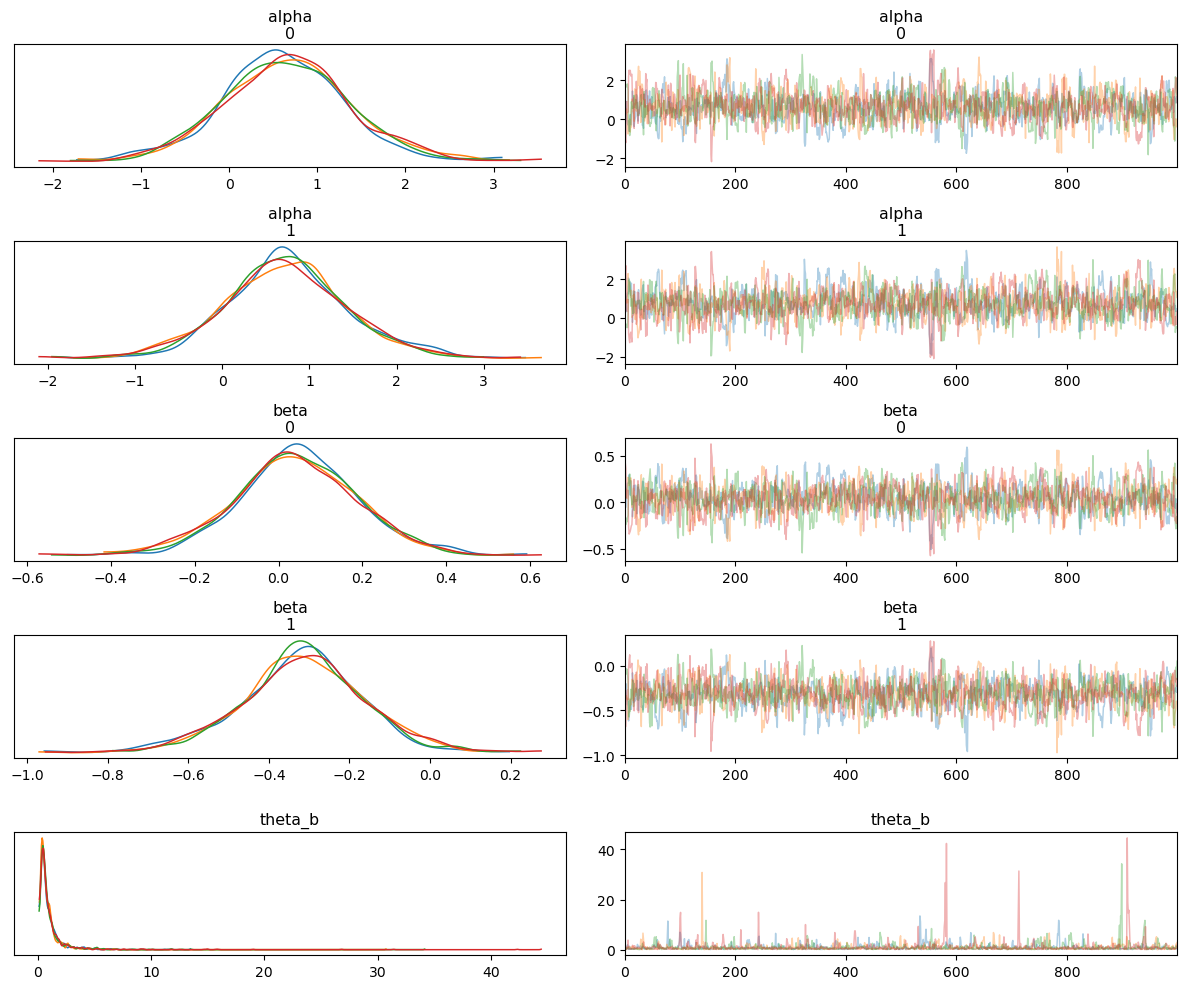

In [7]:
# Check the trace. Looks good!
az.plot_trace(trace, var_names=["alpha", "beta", "theta_b"], compact=False)

plt.tight_layout()
plt.show()

In [8]:
# make predictions
alpha = np.concatenate(
    trace['posterior']['alpha'],
    axis=0
)

beta = np.concatenate(
    trace['posterior']['beta'],
    axis=0
)

beta

print(X.shape)
print(alpha.shape)


p_pred = special.expit(
    (alpha @ X).mean(axis=0) +( beta @ X).mean(axis=0) * price
)

p_pred = special.expit(
  alpha @ X + np.array([x*price for x in beta @ X])
).mean(axis=0)

y_pred = (p_pred >= 0.5).astype(int)

print(
    "Accuracy:",
    (y_pred == y).sum() / len(y)
)

(2, 100)
(4000, 2)
Accuracy: 0.74


In [9]:
# plot price vs uncertainty
# or revenue vs uncertainty
def discretize_prices_(price):
    # discretize prices
    low_price = price.quantile(0.10)
    high_price = price.quantile(0.90)

    prices = np.linspace(low_price, high_price, 9)
    return prices

In [10]:
# discretize prices
prices = discretize_prices_(price)

# get coefficients
alpha = np.concatenate(
    trace['posterior']['alpha'],
    axis=0
)
beta = np.concatenate(
    trace['posterior']['beta'],
    axis=0
)

price_vs_var = []
price_vs_avg = []
for price_ in prices:
  p_avg = special.expit(
    alpha @ X + np.array([x*price_ for x in beta @ X])
  ).mean(axis=0)

  p_var = special.expit(
    alpha @ X + np.array([x*price_ for x in beta @ X])
  ).var(axis=0)

  price_vs_var.append(p_var)
  price_vs_avg.append(p_avg)

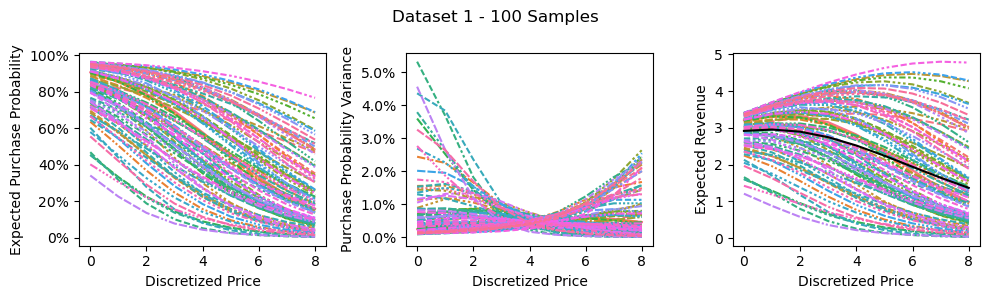

In [11]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(1, 3, figsize=(10, 3))

# plot mean purchase prob
g1 = sns.lineplot(
    data=np.array(price_vs_avg)*100,
    ax=ax[0]
)

# plot var in purchase prob
g2 = sns.lineplot(
    data=np.array(price_vs_var)*100,
    ax=ax[1]
)

# g2 = sns.lineplot(
#     data=np.array([purchase_prob * p for p, purchase_prob in zip(prices, price_vs_var)]),
#     ax=ax[1]
# )

g3 = sns.lineplot(
  data=np.array([purchase_prob * p for p, purchase_prob in zip(prices, price_vs_avg)]),
  ax=ax[2]
)

# average line plot
sns.lineplot(
  data=np.array([purchase_prob * p for p, purchase_prob in zip(prices, price_vs_avg)]).mean(axis=1),
  ax=ax[2],
  color='black'
)

for i in range(3):
  ax[i].get_legend().remove()


ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())

ax[0].set_ylabel("Expected Purchase Probability")
ax[0].set_xlabel("Discretized Price")

ax[1].set_ylabel("Purchase Probability Variance")
ax[1].set_xlabel("Discretized Price")

ax[2].set_ylabel("Expected Revenue")
ax[2].set_xlabel("Discretized Price")

plt.suptitle("Dataset 1 - 100 Samples")

plt.tight_layout()
plt.savefig("figures/dataset1 binomial regressoin samples.png")
plt.show()

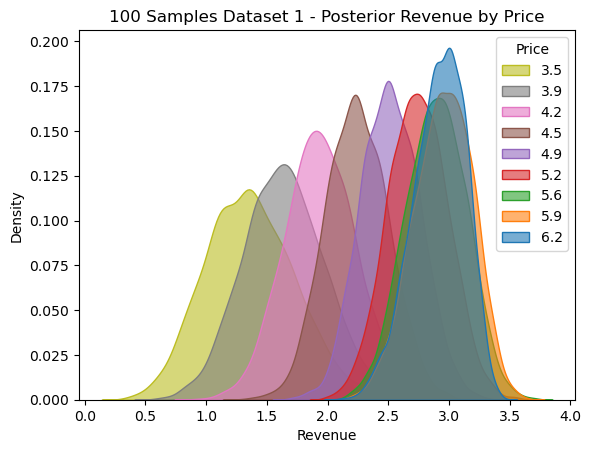

In [14]:
sns.kdeplot(
    data=np.array([
        price * special.expit(
            alpha @ X + np.array([x*price for x in beta @ X])
        ).mean(axis=1)
        for price in prices
    ]).T,
    alpha=0.6,
    fill=True,
    # palette="crest",
    #linewidth=0
)

plt.title("100 Samples Dataset 1 - Posterior Revenue by Price")
plt.legend([round(price, 1) for price in prices], title="Price")
plt.xlabel("Revenue")

plt.savefig("figures/dataset1 revenue posterior over price.png")
plt.show()

In [79]:
class BinomialRegression:

    def __init__(self, alpha, beta):
        self.alpha=alpha
        self.beta=beta

    def get_revenue_pred(self, price, X):
        X = X.to_numpy()
        return price * special.expit(
                self.alpha @ X.T + np.array([x*price for x in self.beta @ X.T])
            )

    def predict_proba(self, X, price):
        X = X.to_numpy()
        p = special.expit(
                self.alpha @ X.T + np.array([x*price for x in self.beta @ X.T])
            ).mean(axis=0)

        return p


teacher = BinomialRegression(alpha, beta)

In [73]:
teacher.predict_proba(data[['X0', 'X1']], price).shape

(100,)

In [100]:
from RiskControlledSPT import RiskControlledSPT

tree = RiskControlledSPT(
    teacher_model=teacher,
    max_depth=3,
    upper_confidence=0.95,
    lower_confidence=0.05
)

tree.fit(data[['X0', 'X1']], price)

In [94]:
tree.rev

(4000, 2)

In [147]:
def get_rev(tree, depth):

    revs = []
    # get leave nodes for tree
    if X_test is None:
        leaf_nodes = tree.get_nodes(depth=depth)
    else:
        leaf_nodes = tree.get_test_nodes(X_test, max_depth=depth)

    for leaf_node in leaf_nodes:
        # get price index
        k = leaf_node['price']
        # get datapoints
        S = leaf_node['datapoints']

        # we can then reference the underlying
        # generative model to determine if the 
        # user purchases or does not
        rev = self.true_revenue_matrix[S, k].sum()

        #total_revenue.append(partition_rev)
        revs.append(rev)

    return revs

array([[6.23972331, 3.78182857, 4.08883691],
       [4.052702  , 4.28239861, 5.37533834]])

(array([  19.,  123.,  570., 1178., 1161.,  641.,  224.,   67.,   12.,
           5.]),
 array([0.07492547, 0.11064769, 0.14636991, 0.18209213, 0.21781436,
        0.25353658, 0.2892588 , 0.32498102, 0.36070324, 0.39642547,
        0.43214769]),
 <BarContainer object of 10 artists>)

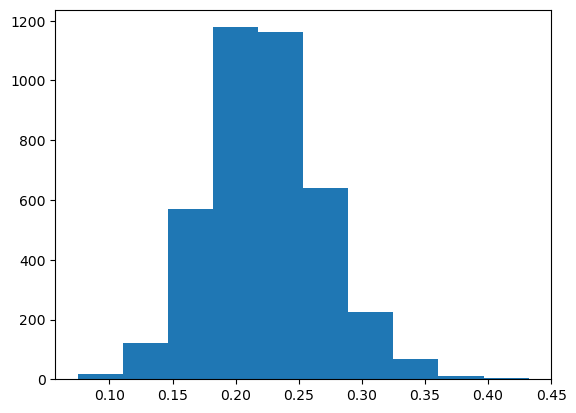

In [136]:
plt.hist(x)